# sklearn Logistic 모델로부터 FIM과 고유값 및 고유벡터 구하기

In [ ]:
import numpy as np
from itertools import combinations, chain
from math import factorial
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from scipy.optimize import minimize

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#device='cuda:0'
device='cpu'

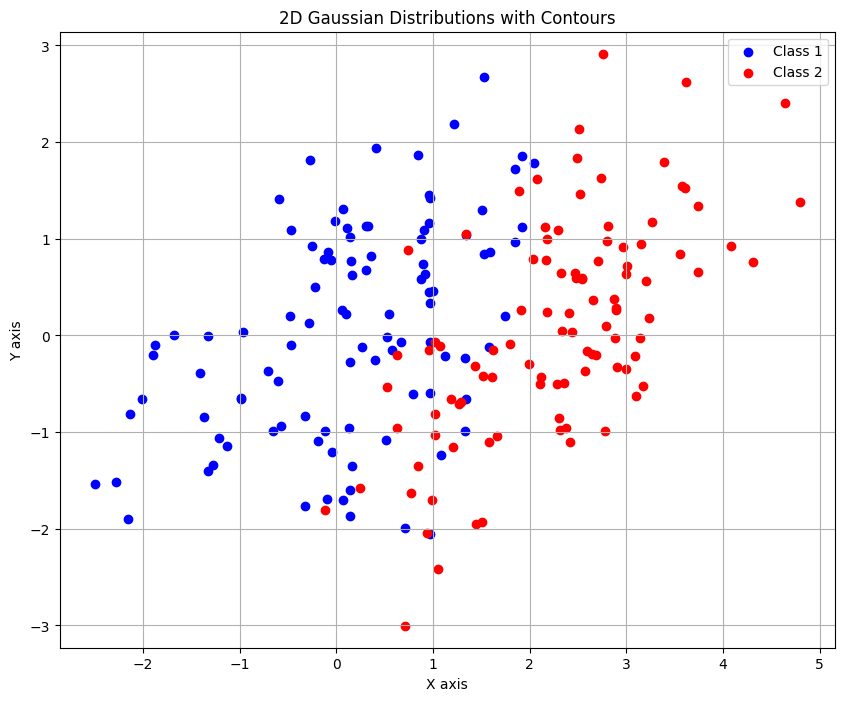

In [ ]:
dim = 2
datanum1 = 100
datanum2 = 100
m1 = torch.tensor([0,0], dtype=torch.float32)
Sig1 = torch.tensor([[1,0.5],[0.5,1]], dtype=torch.float32)
m2 = torch.tensor([2,0], dtype=torch.float32)
Sig2 = torch.tensor([[1,0.5],[0.5,1]], dtype=torch.float32)

L = torch.linalg.cholesky(Sig1)
data1 = torch.matmul(torch.randn([datanum1,dim], device=device), L.to(device).T) + m1.to(device)
L = torch.linalg.cholesky(Sig2)
data2 = torch.matmul(torch.randn([datanum2,dim], device=device), L.to(device).T) + m2.to(device)

all_data = torch.cat([data1, data2]).numpy()
ys = torch.cat([1*torch.ones(datanum1), 0*torch.ones(datanum2)]).to(device).numpy()

# Plotting
plt.figure(figsize=(10, 8))
plt.axis('equal')
plt.grid(True)
plt.scatter(data1[:, 0], data1[:, 1], color='blue', label='Class 1')
plt.scatter(data2[:, 0], data2[:, 1], color='red', label='Class 2')
plt.title('2D Gaussian Distributions with Contours')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
plt.show()

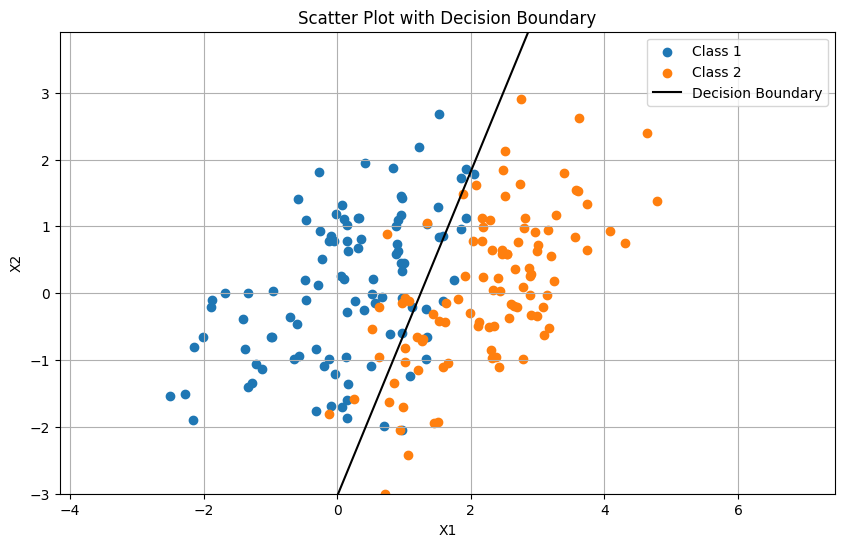

In [ ]:
# 로지스틱 회귀 모델 생성 및 학습
model = LogisticRegression(fit_intercept=True)
model.fit(all_data, ys)

# 결정 경계 시각화
x1 = np.linspace(all_data[:, 0].min(), all_data[:, 0].max(), 100)
w = model.coef_[0]
b = model.intercept_[0]
x2 = -(w[0] * x1 + b) / w[1]

plt.figure(figsize=(10, 6))
plt.scatter(data1[:,0], data1[:,1], label='Class 1')
plt.scatter(data2[:,0], data2[:,1], label='Class 2')
plt.plot(x1, x2, 'k', label='Decision Boundary')  # 결정 경계 직선
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.axis('equal')
plt.grid(True)
plt.xlim(np.min(all_data[:,0]), np.max(all_data[:,0])+1)
plt.ylim(np.min(all_data[:,1]), np.max(all_data[:,1])+1)
plt.title('Scatter Plot with Decision Boundary')
plt.show()


In [ ]:
# Fisher Information Matrix 계산
def compute_fisher_information(X, th0 ,th1, th2):
    X_with_intercept = np.hstack((np.ones((X.shape[0], 1)), X))
    p = 1 / (1 + np.exp(-(th0 * X_with_intercept[:, 0] + th1 * X_with_intercept[:, 1] + th2 * X_with_intercept[:, 2])))
    S = np.diag(p * (1 - p))
    mean = []
    for i in range(X.shape[0]):
      weihted_mean = (X[i,:] * S[i,i])
      mean.append(weihted_mean)
    mean_matrix = np.mean(mean, axis=0).reshape(1, 2)
    fisher_info = (np.array(X)-mean_matrix).T @ S @ (np.array(X)-mean_matrix)
    return fisher_info

# 현재 파라미터에 대한 FIM 계산
theta_0 = b
theta_1, theta_2 = w

current_fisher_info = compute_fisher_information(all_data, theta_0, theta_1, theta_2)

current_fisher_info

array([[35.02930279,  9.82636031],
       [ 9.82636031, 25.28220613]])

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(current_fisher_info)
eigenvalues, eigenvectors

(array([41.12429266, 19.18721626]),
 array([[ 0.84980018, -0.52710498],
        [ 0.52710498,  0.84980018]]))

In [ ]:
# Objective 0: Check if one of the eigenvector has same direction to delta mu

for u in eigenvectors:
  print(np.inner(u, w))

-2.8605278319141396
-0.47535515055308364


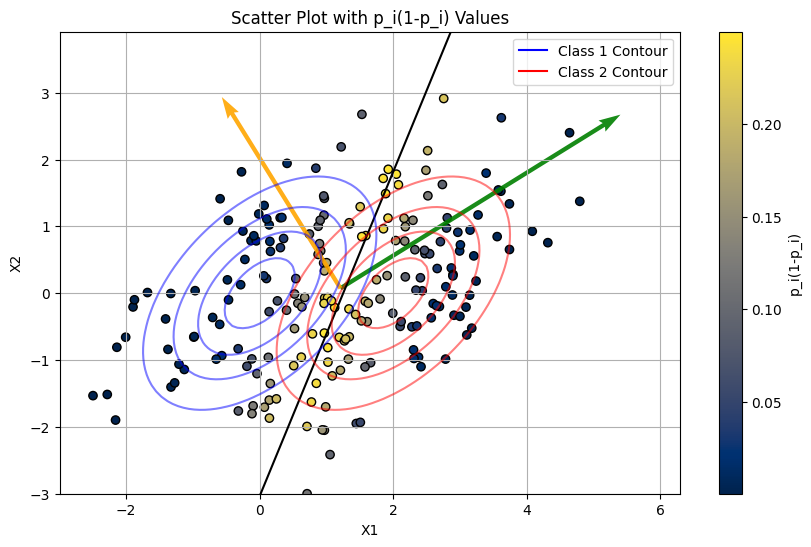

In [ ]:
# 데이터 포인트의 확률 p_i 계산 및 p_i(1-p_i) 계산
probabilities = model.predict_proba(all_data)
p_i = probabilities[np.arange(len(ys)), ys.astype(int)]
p_i_1_p_i = p_i * (1 - p_i)

eigenvalues, eigenvectors

x, y = np.linspace(-3, 5, 100), np.linspace(-3, 5, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# 클래스 별 가우시안 분포 생성
rv1 = multivariate_normal(m1, Sig1)
rv2 = multivariate_normal(m2, Sig2)

# 계산된 PDF를 이용하여 컨투어 플롯 생성
Z1 = rv1.pdf(pos)
Z2 = rv2.pdf(pos)

# Scatter plot에 색깔로 p_i(1-p_i) 값 표현
plt.figure(figsize=(10, 6))
plt.axis('equal')
plt.grid(True)
plt.scatter(all_data[:, 0], all_data[:, 1], c=p_i_1_p_i, cmap='cividis', edgecolor='k')
plt.plot(x1, x2, 'k', label='Decision Boundary')  # 결정 경계 직선
plt.colorbar(label='p_i(1-p_i)')
plt.xlabel('X1')
plt.ylabel('X2')

for i in range(2):
  start, end = [np.mean(all_data[:,0]), np.mean(all_data[:,1])], eigenvectors[:, i] * np.sqrt(eigenvalues[i])  # 고유값으로 스케일 조정
  plt.quiver(start[0], start[1], end[0], end[1], angles='xy', scale_units='xy', scale=1.3, color=['green','orange'][i], width=0.007, alpha=0.9, label=['Eigenvector1','Eigenvector2'][i])

# 데이터 및 가우시안 컨투어 플롯
contour1 = plt.contour(X, Y, Z1, levels=5, colors='blue', alpha=0.5)
contour2 = plt.contour(X, Y, Z2, levels=5, colors='red', alpha=0.5)

# 컨투어 라인을 레전드에 추가
contour_line1 = plt.Line2D([0], [0], color='blue', label='Class 1 Contour')
contour_line2 = plt.Line2D([0], [0], color='red', label='Class 2 Contour')

# 레전드 생성
plt.legend(handles=[contour_line1, contour_line2])
plt.xlim(np.min(all_data[:,0]), np.max(all_data[:,0])+1)
plt.ylim(np.min(all_data[:,1]), np.max(all_data[:,1])+1)
plt.title('Scatter Plot with p_i(1-p_i) Values')
plt.show()

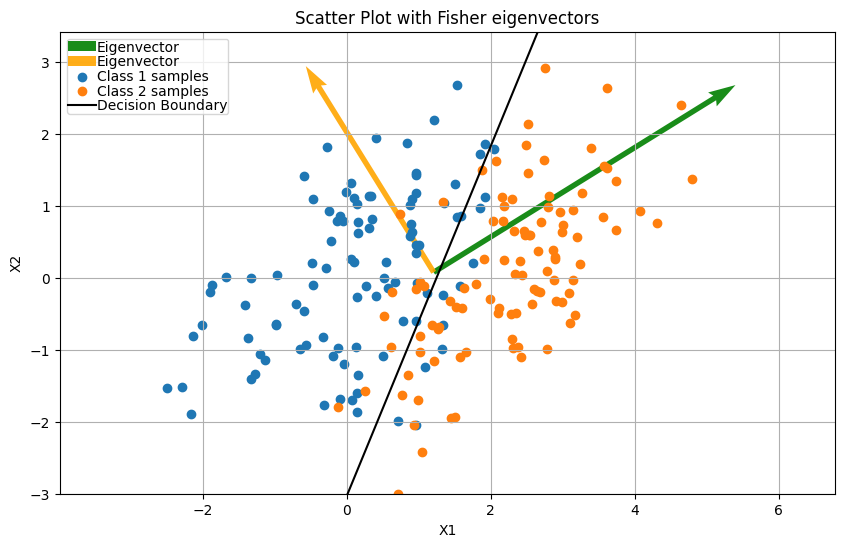

In [ ]:
# 데이터 포인트의 확률 p_i 계산 및 p_i(1-p_i) 계산
probabilities = model.predict_proba(all_data)
p_i = probabilities[np.arange(len(ys)), ys.astype(int)]
p_i_1_p_i = p_i * (1 - p_i)

eigenvalues, eigenvectors
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.axis('equal')
for i in range(2):
  start, end = [np.mean(all_data[:,0]), np.mean(all_data[:,1])], eigenvectors[:, i] * np.sqrt(eigenvalues[i])  # 고유값으로 스케일 조정
  plt.quiver(start[0], start[1], end[0], end[1], angles='xy', scale_units='xy', scale=1.3, color=['green','orange'][i], width=0.007, alpha=0.9, label='Eigenvector')

plt.scatter(data1[:,0], data1[:,1], label='Class 1 samples')
plt.scatter(data2[:,0], data2[:,1], label='Class 2 samples')
plt.plot(x1, x2, 'k', label='Decision Boundary')
plt.xlabel('X1')
plt.ylabel('X2')
plt.xlim(np.min(all_data[:,0]), np.max(all_data[:,0])+0.5)
plt.ylim(np.min(all_data[:,1]), np.max(all_data[:,1])+0.5)
plt.title('Scatter Plot with Fisher eigenvectors')
plt.legend(handletextpad=0.05, borderpad=0.1, labelspacing=0.05)
plt.show()

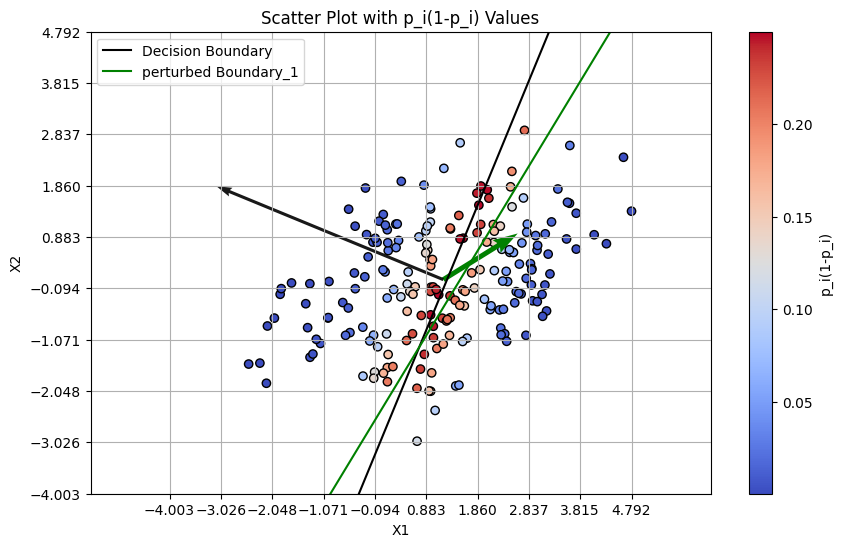

In [ ]:
# 데이터 포인트의 확률 p_i 계산 및 p_i(1-p_i) 계산
probabilities = model.predict_proba(all_data)
p_i = probabilities[np.arange(len(ys)), ys.astype(int)]
p_i_1_p_i = p_i * (1 - p_i)

# 고유벡터 방향으로 파라미터 변경
w = model.coef_[0]
b = model.intercept_[0]
epsilon = 0.5
new_theta_1 = w + epsilon * eigenvectors[:,0]
x1_purturbed_1 = np.linspace(all_data[:, 0].min(), all_data[:, 0].max(), 100)
x2_purturbed_1 = -(new_theta_1[0] * x1 + b) / new_theta_1[1]

# Scatter plot에 색깔로 p_i(1-p_i) 값 표현
plt.figure(figsize=(10, 6))
scatter = plt.scatter(all_data[:, 0], all_data[:, 1], c=p_i_1_p_i, cmap='coolwarm', edgecolor='k')
plt.plot(x1, x2, 'k', label='Decision Boundary')  # 결정 경계 직선
plt.plot(x1_purturbed_1, x2_purturbed_1, 'g', label='perturbed Boundary_1')  # 섭동시킨 경계
plt.colorbar(scatter, label='p_i(1-p_i)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot with p_i(1-p_i) values and Eigenvectors')

# 고유벡터 화살표 그리기
start, end = [np.mean(all_data[:,0]), np.mean(all_data[:,1])], eigenvectors[:, 0] * epsilon  # 고유값으로 스케일 조정
plt.quiver(start[0], start[1], end[0], end[1], angles='xy', scale_units='xy', scale=0.3, color=['green'], width=0.008, alpha=1)

#기존 경계 파라미터 방향
start, end = [np.mean(all_data[:,0]), np.mean(all_data[:,1])], w * np.linalg.norm(w)
plt.quiver(start[0], start[1], end[0], end[1], angles='xy', scale_units='xy', scale=1.8, color=['black'], width=0.005, alpha=0.9)


x1_min, x1_max = np.min(all_data[:,0])+1 , np.max(all_data[:,0])

x2_min, x2_max = np.min(all_data[:,1]) - 1, np.max(all_data[:,1]) + 1

# X1과 X2 축의 범위가 동일하도록 조정
axis_min = min(x1_min, x2_min)
axis_max = max(x1_max, x2_max)

# 그리드 라인의 위치를 계산
num_grid_lines = 10
grid_lines = np.linspace(axis_min, axis_max, num_grid_lines)

# 그리드 라인과 눈금 설정
plt.grid(True)
plt.xticks(grid_lines)
plt.yticks(grid_lines)

# 그래프의 나머지 부분을 설정
plt.axis('equal')
plt.xlim(axis_min, axis_max)
plt.ylim(axis_min, axis_max)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot with p_i(1-p_i) Values')
plt.legend()
plt.show()

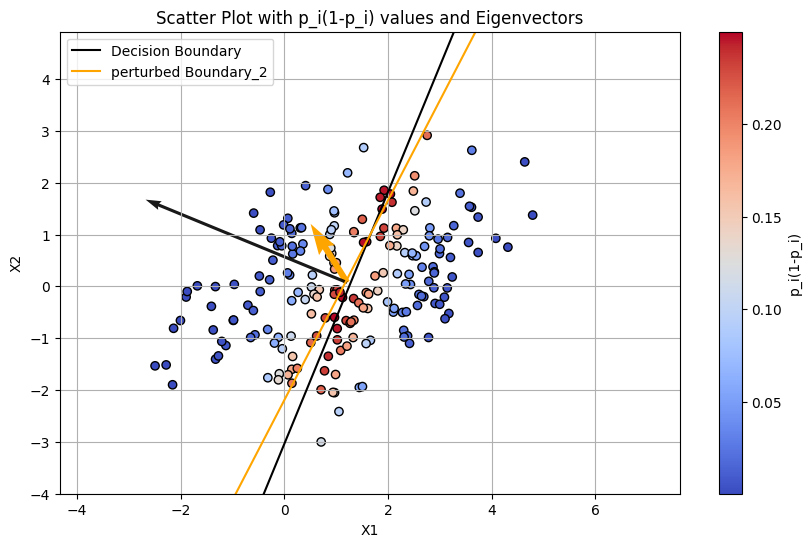

In [ ]:
# 고유벡터 방향으로 파라미터 변경
w = model.coef_[0]
b = model.intercept_[0]
epsilon = 0.5

new_theta_2 = w + epsilon * eigenvectors[:,1]
x1_purturbed_2 = np.linspace(all_data[:, 0].min(), all_data[:, 0].max(), 100)
x2_purturbed_2 = -(new_theta_2[0] * x1 + b) / new_theta_2[1]


# Scatter plot에 색깔로 p_i(1-p_i) 값 표현
plt.figure(figsize=(10, 6))
scatter = plt.scatter(all_data[:, 0], all_data[:, 1], c=p_i_1_p_i, cmap='coolwarm', edgecolor='k')
plt.plot(x1, x2, 'k', label='Decision Boundary')  # 결정 경계 직선
plt.plot(x1_purturbed_2, x2_purturbed_2, 'orange', label='perturbed Boundary_2')  # 섭동시킨 경계
plt.colorbar(scatter, label='p_i(1-p_i)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot with p_i(1-p_i) values and Eigenvectors')

# 고유벡터 화살표 그리기

start, end = [np.mean(all_data[:,0]), np.mean(all_data[:,1])], eigenvectors[:, 1] * 0.4  # 고유값으로 스케일 조정
plt.quiver(start[0], start[1], end[0], end[1], angles='xy', scale_units='xy', scale=0.3, color=['orange'], width=0.01, alpha=1)

start, end = [np.mean(all_data[:,0]), np.mean(all_data[:,1])], w *np.linalg.norm(w)
plt.quiver(start[0], start[1], end[0], end[1], angles='xy', scale_units='xy', scale=2, color=['black'], width=0.005, alpha=0.9)

plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.axis('equal')
plt.xlim(np.min(all_data[:,0]) -1, np.max(all_data[:,0]) + 2)
plt.ylim(np.min(all_data[:,1]) -1, np.max(all_data[:,1]) + 2)
plt.legend()
plt.show()


# 로직스틱 회귀 모델을 단층 신경망으로 표현

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device='cpu'

In [ ]:
# 로지스틱 회귀 모델 클래스
class LogisticRegression2(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression2, self).__init__()
        self.w = torch.randn([1, input_dim], dtype=torch.float64, device=device, requires_grad=True)
        self.mu = torch.randn([1, input_dim], dtype=torch.float64, device=device, requires_grad=True)

    def get_loss(self, data, labels):
        fs = self.forward(data)
        loss_val = torch.sum(-labels * torch.log(fs) - (1 - labels) * torch.log(1 - fs))
        return loss_val

    def forward(self, x):
        outputs = torch.sigmoid(torch.matmul(self.w, (x - self.mu).T))
        return outputs

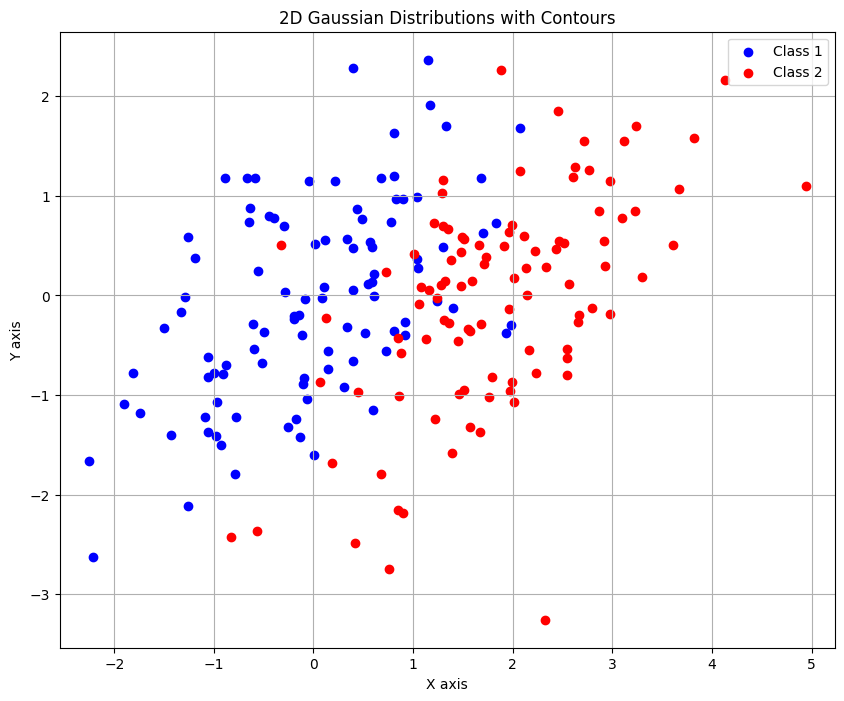

In [ ]:
dim = 2
datanum1 = 100
datanum2 = 100
m1 = torch.tensor([0,0], dtype=torch.float32)
Sig1 = torch.tensor([[1,0.5],[0.5,1]], dtype=torch.float32)
m2 = torch.tensor([2,0], dtype=torch.float32)
Sig2 = torch.tensor([[1,0.5],[0.5,1]], dtype=torch.float32)

L = torch.linalg.cholesky(Sig1)
data1 = torch.matmul(torch.randn([datanum1,dim], device=device), L.to(device).T) + m1.to(device)
L = torch.linalg.cholesky(Sig2)
data2 = torch.matmul(torch.randn([datanum2,dim], device=device), L.to(device).T) + m2.to(device)

all_data = torch.cat([data1, data2])
labels = torch.cat([1*torch.ones(datanum1), 0*torch.ones(datanum2)]).to(device)
labels = labels.reshape(-1,1)
# Plotting
plt.figure(figsize=(10, 8))
plt.axis('equal')
plt.grid(True)
plt.scatter(data1[:, 0], data1[:, 1], color='blue', label='Class 1')
plt.scatter(data2[:, 0], data2[:, 1], color='red', label='Class 2')
plt.title('2D Gaussian Distributions with Contours')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
plt.show()

In [ ]:
def update_param(model, data, labels, num_update=100, step_size=0.001):
    optimizer = torch.optim.SGD([model.w, model.mu], lr=step_size)
    objective_history = []

    for i in range(num_update):
        cost = model.get_loss(data, labels)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        objective_history.append(float(cost))

In [ ]:
data = torch.cat([data1, data2], axis=0)
labels = torch.cat([torch.ones(datanum1), torch.zeros(datanum2)])  # label of class 1: 1, label of class 2: 0

model = LogisticRegression2(input_dim=dim, output_dim=1)
update_param(model, data, labels, num_update=800, step_size=0.001)

# mu의 영향력이 작고 w의 영향력이 큰 데이터 분포

Learned parameters:
theta_1: -0.9585381746292114
theta_2: -0.021254390478134155
mu: [0.45755225 0.38653305]


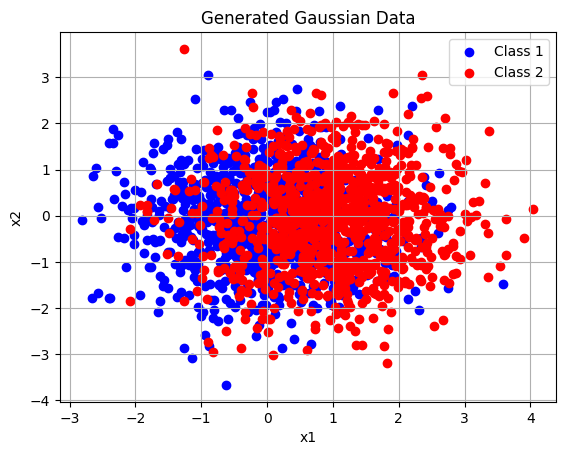

In [ ]:
# 데이터 생성 함수
def generate_gaussian_data(mean, cov, num_samples):
    return np.random.multivariate_normal(mean, cov, num_samples)

# Logistic Regression Model with mu
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(2, 1, bias=False)  # 편향 제거
        self.mu = nn.Parameter(torch.zeros(2))  # mu 파라미터 추가

    def forward(self, x):
        out = torch.sigmoid(self.linear(x - self.mu))  # (x - mu)
        return out


# 데이터 생성 (클래스 간 데이터 중심이 멀리 떨어져 있고, 분산이 작은 경우)
mean_class1 = np.array([0, 0])
mean_class2 = np.array([1, 0])
sigma = 1  # 작은 분산
cov_matrix = np.array([[sigma**2, 0], [0, sigma**2]])

data_class1 = generate_gaussian_data(mean_class1, cov_matrix, 1000)
data_class2 = generate_gaussian_data(mean_class2, cov_matrix, 1000)

all_data = np.vstack((data_class1, data_class2))
labels = np.hstack((np.ones(1000), np.zeros(1000)))

# PyTorch 텐서로 변환
all_data_tensor = torch.tensor(all_data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)

# 모델 정의 및 학습
model = LogisticRegressionModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 모델 학습
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    outputs = model(all_data_tensor)
    loss = criterion(outputs, labels_tensor)
    loss.backward()
    optimizer.step()

# 학습된 파라미터 확인
theta_1, theta_2 = model.linear.weight.view(-1).tolist()
mu = model.mu.detach().cpu().numpy()

print("Learned parameters:")
print("theta_1:", theta_1)
print("theta_2:", theta_2)
print("mu:", mu)

# 데이터 시각화
plt.scatter(data_class1[:, 0], data_class1[:, 1], color='blue', label='Class 1')
plt.scatter(data_class2[:, 0], data_class2[:, 1], color='red', label='Class 2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Generated Gaussian Data')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Fisher Information Matrix 계산 함수
def compute_fisher_information(X, y, th1, th2, mu):
    th1, th2 = torch.tensor([th1], dtype=torch.float32).to(device), torch.tensor([th2], dtype=torch.float32).to(device)
    mu = torch.tensor(mu, dtype=torch.float32).to(device)
    X = X - mu  # (x - mu)

    linear_combination = th1 * X[:, 0] + th2 * X[:, 1]
    p = torch.sigmoid(linear_combination)

    fisher_info_w = torch.zeros((2, 2), dtype=torch.float32).to(device)
    fisher_info_mu = torch.zeros((2, 2), dtype=torch.float32).to(device)
    fisher_info_w_mu = torch.zeros((2, 2), dtype=torch.float32).to(device)

    for i in range(X.shape[0]):
        x_i = X[i].reshape(-1, 1)
        common_term = p[i] * (1 - p[i])
        fisher_info_w += common_term * (x_i) @ (x_i).T
        fisher_info_mu += common_term * torch.outer(torch.tensor([th1, th2]), torch.tensor([th1, th2]))
        fisher_info_w_mu += common_term * torch.outer(torch.tensor([th1, th2]), x_i.view(-1)) + (y[i] - p[i]) * torch.tensor([[0, 1], [1, 0]], dtype=torch.float32).to(device)

    fisher_info_w /= X.shape[0]
    fisher_info_mu /= X.shape[0]
    fisher_info_w_mu /= X.shape[0]

    return fisher_info_w.cpu().numpy(), fisher_info_mu.cpu().numpy(), fisher_info_w_mu.cpu().numpy()

# Fisher Information Matrix 계산
fisher_info_w, fisher_info_mu, fisher_info_w_mu = compute_fisher_information(all_data_tensor, labels_tensor, theta_1, theta_2, mu)

# FIM을 4x4 행렬로 확장
FIM = np.zeros((4, 4))
FIM[:2, :2] = fisher_info_w
FIM[2:, 2:] = fisher_info_mu
FIM[:2, 2:] = fisher_info_w_mu
FIM[2:, :2] = fisher_info_w_mu.T

# 4x4 FIM의 고유값과 고유벡터 계산
eigenvalues, eigenvectors = np.linalg.eig(FIM)
max_eigenvalue_index = np.argmax(eigenvalues)
principal_eigenvector = eigenvectors[:, max_eigenvalue_index]

print("Eigenvalues:\n", eigenvalues)
print("Principal Eigenvector (corresponding to the largest eigenvalue):\n", principal_eigenvector)

Eigenvalues:
 [-0.03637558  0.25337842  0.20242209  0.18692265]
Principal Eigenvector (corresponding to the largest eigenvalue):
 [ 2.84670811e-02 -9.99592450e-01 -1.29168165e-04  2.13121659e-03]


# mu의 영향력이 커져서 w의 영향력이 작은 데이터 분포

# mu의 w에 수직인 방향으로 이동

# 로지스틱 모델 신경망의 히든레이어 추가 확장 후 FIM 계산

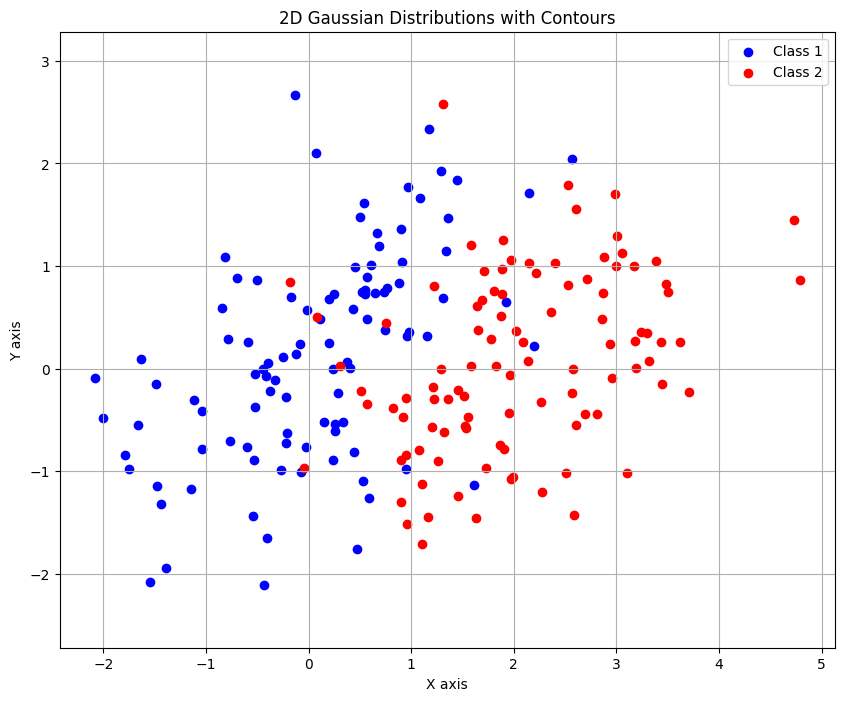

W1: [[-1.6709048   2.7972827 ]
 [ 0.92970735 -0.06751686]]
W2: [[ 1.6137865 -1.2042116]]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
# 데이터 생성
dim = 2
datanum1 = 100
datanum2 = 100
m1 = torch.tensor([0, 0], dtype=torch.float32)
Sig1 = torch.tensor([[1, 0.5], [0.5, 1]], dtype=torch.float32)
m2 = torch.tensor([2, 0], dtype=torch.float32)
Sig2 = torch.tensor([[1, 0.5], [0.5, 1]], dtype=torch.float32)

L = torch.linalg.cholesky(Sig1)
data1 = torch.matmul(torch.randn([datanum1, dim]), L.T) + m1
L = torch.linalg.cholesky(Sig2)
data2 = torch.matmul(torch.randn([datanum2, dim]), L.T) + m2

all_data = torch.cat([data1, data2])
ys = torch.cat([torch.ones(datanum1), torch.zeros(datanum2)]).reshape(-1, 1)

# 데이터 시각화
plt.figure(figsize=(10, 8))
plt.axis('equal')
plt.grid(True)
plt.scatter(data1[:, 0], data1[:, 1], color='blue', label='Class 1')
plt.scatter(data2[:, 0], data2[:, 1], color='red', label='Class 2')
plt.title('2D Gaussian Distributions with Contours')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
plt.show()

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(2, 2, bias=False)  # 은닉층 (2, 2)
        self.output = nn.Linear(2, 1, bias=False)  # 출력층 (2, 1)

    def forward(self, x):
        h = torch.relu(self.hidden(x))
        out = torch.sigmoid(self.output(h))
        return out

model = NeuralNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

all_data = torch.cat([data1, data2])
ys = torch.cat([torch.ones(datanum1), torch.zeros(datanum2)]).reshape(-1, 1)

# 모델 학습
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    outputs = model(all_data)
    loss = criterion(outputs, ys)
    loss.backward()
    optimizer.step()

# 학습된 파라미터 확인
W1 = model.hidden.weight.detach().numpy()
W2 = model.output.weight.detach().numpy()
print("W1:", W1)
print("W2:", W2)


In [ ]:
# 은닉층과 출력층의 FIM 계산 함수 정의
def compute_fisher_information(hidden_output, output, y, W1, W2):
    p = output.detach().numpy().flatten()
    y = y.detach().numpy().flatten()
    h = hidden_output.detach().numpy()
    x = all_data.numpy()

    fisher_info_output = np.zeros((2, 2))  # 출력층은 3x3 행렬
    fisher_info_hidden = np.zeros((4, 4))  # 은닉층은 6x6 행렬

    for i in range(len(p)):
        p_i = p[i]
        y_i = y[i]
        h_i = h[i].reshape(-1, 1)
        x_i = x[i].reshape(1, -1)  # (1, 2)

        # 출력층의 FIM 계산
        fisher_info_output += p_i * (1 - p_i) * (h_i @ h_i.T)

        # 은닉층의 이계도함수 계산
        sigma_prime = p_i * (1 - p_i)
        relu_prime = (W1 @ x_i.T > 0).astype(float).flatten()
        grad_hidden = np.outer(W2.flatten(), x_i.flatten())
        for j in range(2):
            grad_hidden[j] *= sigma_prime * relu_prime[j]
        grad_hidden_flat = grad_hidden.flatten().reshape(-1, 1)
        fisher_info_hidden += grad_hidden_flat @ grad_hidden_flat.T

    return fisher_info_output, fisher_info_hidden

# 은닉층 출력 및 모델 예측 계산
hidden_output = torch.relu(model.hidden(all_data))
output = model(all_data)

# FIM 계산
fisher_info_output, fisher_info_hidden = compute_fisher_information(hidden_output, output, ys, W1, W2)
fisher_info_output, fisher_info_hidden

(array([[ 9.46872192,  4.44494537],
        [ 4.44494537, 29.97301625]]),
 array([[ 5.02248954,  3.68822943, -2.86216355, -2.36300567],
        [ 3.68822943,  3.00365026, -2.36300558, -2.03680511],
        [-2.86216355, -2.36300558,  5.81756733,  1.00015502],
        [-2.36300567, -2.03680511,  1.00015502,  3.37573643]]))

<ipython-input-34-e67b91d8e50e>:17: UserWarning: linewidths is ignored by contourf
  plt.contourf(xx, yy, hidden_activated_np[:, 0].reshape(xx.shape), alpha=0.2, levels=[-1, 0, 1], linewidths=2, colors=['gray'], linestyles=['-'])
<ipython-input-34-e67b91d8e50e>:18: UserWarning: linewidths is ignored by contourf
  plt.contourf(xx, yy, hidden_activated_np[:, 1].reshape(xx.shape), alpha=0.2, levels=[-1, 0, 1], linewidths=2, colors=['gray'], linestyles=['-'])


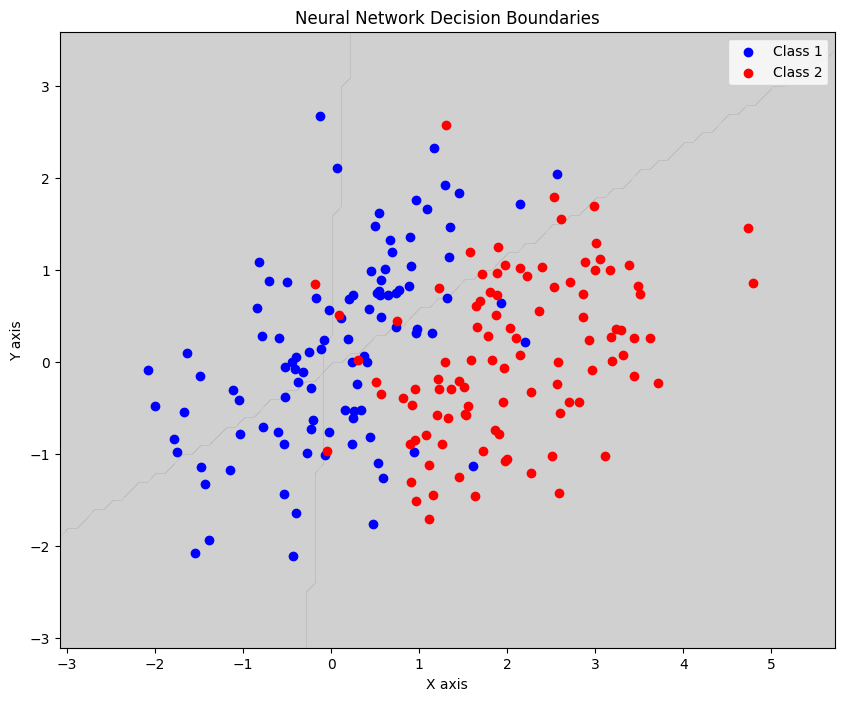

In [ ]:
# 결정 경계 계산
x_min, x_max = all_data[:, 0].min() - 1, all_data[:, 0].max() + 1
y_min, y_max = all_data[:, 1].min() - 1, all_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)
hidden_outputs = model.hidden(grid_tensor)
hidden_activated = hidden_outputs > 0  # 뉴런 활성화 조건

# 활성화된 뉴런의 영역
hidden_activated_np = hidden_activated.detach().numpy()

# 활성화된 영역을 시각화
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, hidden_activated_np[:, 0].reshape(xx.shape), alpha=0.2, levels=[-1, 0, 1], linewidths=2, colors=['gray'], linestyles=['-'])
plt.contourf(xx, yy, hidden_activated_np[:, 1].reshape(xx.shape), alpha=0.2, levels=[-1, 0, 1], linewidths=2, colors=['gray'], linestyles=['-'])

plt.scatter(data1[:, 0], data1[:, 1], color='blue', label='Class 1')
plt.scatter(data2[:, 0], data2[:, 1], color='red', label='Class 2')
plt.title('Neural Network Decision Boundaries')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
plt.show()


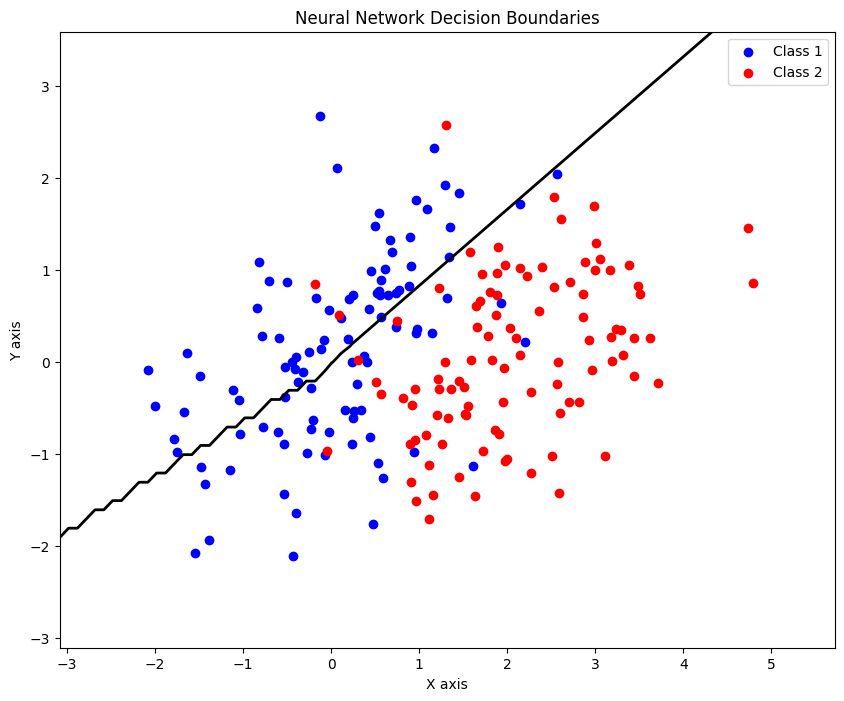

In [ ]:
# 출력 레이어의 결정 경계 계산 및 시각화
outputs = model(grid_tensor)
preds = outputs.detach().numpy()

# 결정 경계 시각화
plt.figure(figsize=(10, 8))
plt.contour(xx, yy, preds.reshape(xx.shape), levels=[0.5], linewidths=2, colors='black')
plt.scatter(data1[:, 0], data1[:, 1], color='blue', label='Class 1')
plt.scatter(data2[:, 0], data2[:, 1], color='red', label='Class 2')
plt.title('Neural Network Decision Boundaries')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
plt.show()


# FIM 코드
자동미분 / 수식 구현

In [1]:
  import torch
  import torch.nn as nn
  import torch.optim as optim
  import matplotlib.pyplot as plt
  import numpy as np

  device = 'cpu'  # Using CPU instead of GPU

  class LogisticRegression1(torch.nn.Module):
      def __init__(self, input_dim):
          super(LogisticRegression1, self).__init__()
          self.w = torch.randn([1, input_dim], dtype=torch.float64, requires_grad=True)
          self.b = torch.randn([1, 1], dtype=torch.float64, requires_grad=True)

      def get_loss(self, data, labels):
          fs = self.forward(data)
          loss_val = torch.sum(-labels * torch.log(fs) - (1 - labels) * torch.log(1 - fs))
          return loss_val

      def forward(self, x):
          outputs = torch.sigmoid(torch.matmul(self.w, x.T) + self.b)
          return outputs

  class LogisticRegression2(torch.nn.Module):
      def __init__(self, input_dim):
          super(LogisticRegression2, self).__init__()
          self.w = torch.randn([1, input_dim], dtype=torch.float64, requires_grad=True)
          self.mu = torch.randn([1, input_dim], dtype=torch.float64, requires_grad=True)

      def get_loss(self, data, labels):
          fs = self.forward(data)
          loss_val = torch.sum(-labels * torch.log(fs) - (1 - labels) * torch.log(1 - fs))
          return loss_val

      def forward(self, x):
          outputs = torch.sigmoid(torch.matmul(self.w, (x - self.mu).T))
          return outputs

  def train_model1(model, data, labels, num_update=1000, step_size=0.01):
      optimizer = torch.optim.SGD([model.w, model.b], lr=step_size)
      for i in range(num_update):
          cost = model.get_loss(data, labels)
          optimizer.zero_grad()
          cost.backward()
          optimizer.step()
      return model.w.detach(), model.b.detach()

  def train_model2(model, data, labels, num_update=1000, step_size=0.01):
      optimizer = torch.optim.SGD([model.w, model.mu], lr=step_size)
      for i in range(num_update):
          cost = model.get_loss(data, labels)
          optimizer.zero_grad()
          cost.backward()
          optimizer.step()
      return model.w.detach(), model.mu.detach()

  # 평행한 데이터 생성 함수
  def generate_designed_data(n_samples, input_dim, shift):
      # y = x 선 위의 점들 생성
      x = torch.linspace(-10, 10, n_samples, dtype=torch.float64)
      y = x

      # 클래스 1: -x 방향으로 평행 이동
      data1 = torch.stack([x - shift, y], dim=1)
      labels1 = torch.ones(n_samples, dtype=torch.float64)

      # 클래스 2: +x 방향으로 평행 이동
      data2 = torch.stack([x + shift, y], dim=1)
      labels2 = torch.zeros(n_samples, dtype=torch.float64)

      # 데이터와 레이블 결합
      data = torch.cat((data1, data2), dim=0)
      labels = torch.cat((labels1, labels2), dim=0)

      return data, labels


  def generate_dense_triangular_data(n_samples, shift):
      # Class 1: points in the left upper triangle
      x1 = torch.empty(n_samples, dtype=torch.float64).uniform_(-5,5)
      y1 = torch.empty(n_samples, dtype=torch.float64).uniform_(-5, 5)
      mask1 = y1 > -x1
      data1 = torch.stack([x1[mask1]+shift, y1[mask1]], dim=1)
      labels1 = torch.ones(len(data1), dtype=torch.float64)

      # Class 2: points in the right lower triangle
      x2 = torch.empty(n_samples, dtype=torch.float64).uniform_(-5,5)
      y2 = torch.empty(n_samples, dtype=torch.float64).uniform_(-5,5)
      mask2 = y2 < -x2
      data2 = torch.stack([x2[mask2]-shift, y2[mask2]], dim=1)
      labels2 = torch.zeros(len(data2), dtype=torch.float64)

      # Combine data and labels
      data = torch.cat((data1, data2), dim=0)
      labels = torch.cat((labels1, labels2), dim=0)

      return data, labels

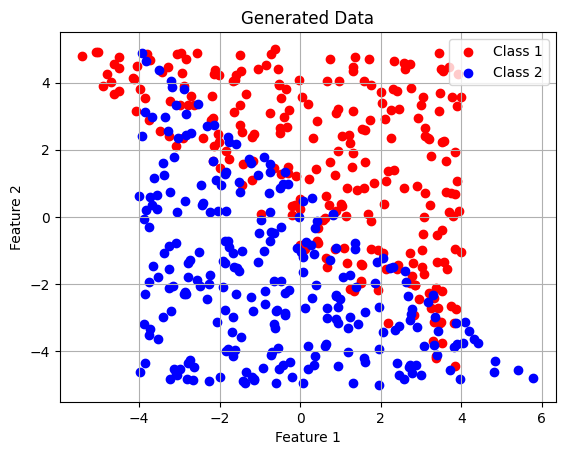

In [2]:
# 두 모델에서 w가 같도록 데이터 설계
dim = 2
n_samples_per_class = 500
shift = -1

# 데이터 생성
#data, labels = generate_designed_data(n_samples_per_class, dim, shift)

data, labels = generate_dense_triangular_data(n_samples_per_class, shift)

# 데이터 시각화
data1 = data[labels == 1]
data2 = data[labels == 0]

# Plot the data
plt.scatter(data1[:, 0], data1[:, 1], c='red', label='Class 1')
plt.scatter(data2[:, 0], data2[:, 1], c='blue', label='Class 2')
plt.title('Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()

In [3]:
# LogisticRegression2 모델 학습
model2 = LogisticRegression2(dim)
w2, mu2 = train_model2(model2, data, labels, num_update=1000, step_size=0.001)


In [5]:
p1_1=model2.forward(data1)
p1_2=model2.forward(data2)
# PyTorch 자동미분을 활용한 FIM 계산
def compute_hessian_autodiff(logits, labels, params):
    loss = torch.sum(torch.log(p1_1)) + torch.sum(torch.log(1. - p1_2))
    grads = torch.autograd.grad(loss, params, create_graph=True)
    grads_flat = torch.cat([g.view(-1) for g in grads])
    hessian = torch.zeros((len(grads_flat), len(grads_flat)), dtype=torch.float64, device=device)
    for i, grad in enumerate(grads_flat):
        grad2 = torch.autograd.grad(grad, params, retain_graph=True)
        hessian[i] = torch.cat([g.contiguous().view(-1) for g in grad2])
    return hessian, grads

logits = (data - model2.mu).mm(model2.w.T)
hessian_autodiff, grads = compute_hessian_autodiff(logits, labels, [model2.w, model2.mu])
fim_autodiff = -hessian_autodiff.detach().cpu().numpy()


In [6]:
fim_autodiff

array([[ 457.36422795, -405.10641872,   76.66554738,   88.4636464 ],
       [-405.10641872,  413.94817791,  -69.46390148,  -80.15373565],
       [  76.66554738,  -69.46390148,   68.59305359,   79.14887255],
       [  88.4636464 ,  -80.15373565,   79.14887255,   91.32913171]])

In [7]:
# 모든 데이터에 대해 파라미터에 대한 손실 함수의 그래디언트를 계산하는 함수
def compute_gradients_for_all_data(model, data, labels, params):
    model.eval()
    gradients = []
    for i in range(data.size(0)):
        single_data = data[i].unsqueeze(0)  # 각 데이터 샘플을 선택하고 차원을 맞추기 위해 unsqueeze 사용
        single_label = labels[i]  # 해당 샘플에 대한 레이블

        single_logit = model.forward(single_data)
        loss = torch.log(single_logit) if single_label == 1 else torch.log(1. - single_logit)
        grads = torch.autograd.grad(loss, params, create_graph=True)

        gradients.append(grads)

    return gradients
# 그래디언트 계산
gradients = compute_gradients_for_all_data(model2, data, labels, [model2.w, model2.mu])

# 각 데이터가 파라미터 공간에서 4개의 좌표의 한 점으로 맵핑 됨
gradients

[(tensor([[ 0.9718, -1.1630]], dtype=torch.float64, grad_fn=<MmBackward0>),
  tensor([[-0.7495, -0.8649]], dtype=torch.float64, grad_fn=<NegBackward0>)),
 (tensor([[0.0003, 0.0040]], dtype=torch.float64, grad_fn=<MmBackward0>),
  tensor([[-0.0009, -0.0010]], dtype=torch.float64, grad_fn=<NegBackward0>)),
 (tensor([[0.1057, 0.0045]], dtype=torch.float64, grad_fn=<MmBackward0>),
  tensor([[-0.0455, -0.0525]], dtype=torch.float64, grad_fn=<NegBackward0>)),
 (tensor([[-1.8409,  1.7689]], dtype=torch.float64, grad_fn=<MmBackward0>),
  tensor([[-0.3841, -0.4432]], dtype=torch.float64, grad_fn=<NegBackward0>)),
 (tensor([[-0.0004,  0.0544]], dtype=torch.float64, grad_fn=<MmBackward0>),
  tensor([[-0.0203, -0.0234]], dtype=torch.float64, grad_fn=<NegBackward0>)),
 (tensor([[-0.2766,  0.1149]], dtype=torch.float64, grad_fn=<MmBackward0>),
  tensor([[-0.6531, -0.7536]], dtype=torch.float64, grad_fn=<NegBackward0>)),
 (tensor([[0.0003, 0.0007]], dtype=torch.float64, grad_fn=<MmBackward0>),
  tens

In [8]:
torch.linalg.eigh(-hessian_autodiff)

torch.return_types.linalg_eigh(
eigenvalues=tensor([-5.4870e-14,  2.9842e+01,  1.2523e+02,  8.7617e+02],
       dtype=torch.float64),
eigenvectors=tensor([[-2.4125e-16,  6.9252e-01,  1.3118e-01, -7.0937e-01],
        [-3.3696e-16,  7.2052e-01, -1.7445e-01,  6.7114e-01],
        [-7.5570e-01, -2.3387e-02, -6.3913e-01, -1.4102e-01],
        [ 6.5492e-01, -2.6986e-02, -7.3748e-01, -1.6272e-01]],
       dtype=torch.float64))

In [9]:
torch.linalg.inv(-hessian_autodiff)

tensor([[ 1.6783e-02,  1.5994e-02,  1.6804e-02, -1.7054e-02],
        [ 1.5994e-02,  1.8154e-02,  1.2760e-02, -1.0721e-02],
        [-1.8796e-03, -4.4394e-03, -3.3613e+13,  2.9130e+13],
        [-5.8977e-04,  4.2871e-03,  2.9130e+13, -2.5245e+13]],
       dtype=torch.float64)

In [ ]:
# 수식으로 유도된 FIM 계산
def compute_fim_manual(X1, X2, p1, p2, theta, mu):
    fim_manual = np.zeros((4, 4))
    for i in range(X1.shape[0]):
        x_i = (X1[i] - mu).reshape(-1, 1)
        common_term = p1[0][i] * (1 - p1[0][i])
        mu_w_add = (1-p1[0][i]) * np.array([[0, 1], [1, 0]])
        fim_manual[0:2, 0:2] += common_term * x_i @ x_i.T
        fim_manual[2:4, 2:4] += common_term * theta.T @ theta
        fim_manual[0:2, 2:4] += common_term * np.outer(x_i, -theta) + mu_w_add
        fim_manual[2:4, 0:2] += common_term * -theta.T @ x_i.T + mu_w_add.T

    for i in range(X2.shape[0]):
        x_i = (X2[i] - mu).reshape(-1, 1)
        common_term = p2[0][i] * (1 - p2[0][i])
        mu_w_add = -p2[0][i].reshape(-1, 1) * np.array([[0, 1], [1, 0]])
        fim_manual[0:2, 0:2] += common_term * (x_i @ x_i.T)
        fim_manual[2:4, 2:4] += common_term * (theta.T @ theta)
        fim_manual[0:2, 2:4] += common_term * np.outer(x_i, -theta) + mu_w_add
        fim_manual[2:4, 0:2] += common_term * (-theta.T @ x_i.T) + mu_w_add.T

    return fim_manual, fim_manual[0:2, 0:2]

# 학습된 파라미터 추출
w = model2.w.detach().cpu().numpy().flatten()
mu = model2.mu.detach().cpu().numpy().flatten()

p1_1=model2.forward(data1)
p1_2=model2.forward(data2)
#p1_1=torch.sigmoid(torch.matmul(model2.w, (data1-mu).T))
#p1_2=torch.sigmoid(torch.matmul(model2.w, (data2-mu).T))

# 수식으로 유도된 FIM 계산
fim_manual, w_space = compute_fim_manual(data1.detach().numpy(), data2.detach().numpy(), p1_1.detach().numpy(), p1_2.detach().numpy(), w.reshape(1, -1), mu.reshape(1, -1))
np.linalg.eigh(fim_manual)

In [ ]:
np.linalg.eigh(w_space)

In [ ]:
def calculate_orthogonal_shift(w):
    orthogonal_direction = torch.tensor([-w[0][1], w[0][0]], dtype=torch.float64)
    return orthogonal_direction / torch.norm(orthogonal_direction)

w = model2.w
orthogonal_shift = calculate_orthogonal_shift(w)
orthogonal_shift_reshaped = orthogonal_shift.unsqueeze(0)
orthogonal_shift_reshaped

In [ ]:
a = torch.matmul(p1_1*(1-p1_1),data1)
b = torch.matmul(p1_2*(1-p1_2),data2)
c = torch.sum(p1_1*(1-p1_1))
d = torch.sum(p1_2*(1-p1_2))
mu_low = (a+b) / (c+d)

In [ ]:
def calculate_orthogonal_shift(w):
    orthogonal_direction = torch.tensor([-w[0][1], w[0][0]], dtype=torch.float64)
    return orthogonal_direction / torch.norm(orthogonal_direction)

w = model2.w
orthogonal_shift = calculate_orthogonal_shift(w)
orthogonal_shift_reshaped = orthogonal_shift.unsqueeze(0)
orthogonal_shift_reshaped

In [ ]:
shift_magnitudes = np.linspace(-200, 200, 25)
max_eigenvalues_w_space = []
max_eigenvector_w_space = []

ortho = orthogonal_shift_reshaped.detach().cpu().numpy().flatten()
w = w = model2.w.detach().cpu().numpy().flatten()

p1_1=model2.forward(data1)
p1_2=model2.forward(data2)
mu_low = mu_low.detach().cpu().numpy()
# Compute the maximum eigenvalue for each shift magnitude
for magnitude in shift_magnitudes:
    new_mu = mu_low + magnitude * ortho
    new_mu_tensor = torch.tensor(new_mu, dtype=torch.float64, device=device).unsqueeze_(0)

    fim_manual, w_space = compute_fim_manual(data1.detach().numpy(), data2.detach().numpy(), p1_1.detach().numpy(), p1_2.detach().numpy(), w.reshape(1, -1), new_mu.reshape(1, -1))
    eigenvalues, eigenvectors = np.linalg.eigh(w_space)
    w_vectors = eigenvectors[:,-1]
    max_eigenvector_w_space.append(w_vectors)

    top_eigenvalue_w_space = eigenvalues[-1]
    max_eigenvalues_w_space.append(top_eigenvalue_w_space)


In [ ]:
eigenvalues, eigenvectors = np.linalg.eigh(fim_manual)
eigenvectors

In [ ]:
fim_manual, w_space = compute_fim_manual(data1.detach().numpy(), data2.detach().numpy(), p1_1.detach().numpy(), p1_2.detach().numpy(), w.reshape(1, -1), mu_low.reshape(1, -1))
eigenvalues, eigenvectors = np.linalg.eigh(fim_manual)
eigenvectors

In [ ]:
# Plot the maximum eigenvalue as a function of the shift magnitude
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, max_eigenvalues_w_space, 'o', markersize=4, label='Max Eigenvalue')
plt.title('Maximum Eigenvalue of w-space')
plt.xlabel('change mu in w_orthogonal direction ')
plt.ylabel('Max Eigenvalue')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Plot the maximum eigenvalue as a function of the shift magnitude
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, max_eigenvector_w_space, 'o', markersize=4, label='Max Eigenvector')
plt.title('Eigenvectors of w-space')
plt.xlabel('change mu in w_orthogonal direction ')
plt.ylabel('Eigenvector')
plt.grid(True)
plt.legend()
plt.show()

# 데이터 분포 실험



Parameter $\mathbf{w}$, $\mathbf{\mu}$

Model:
\begin{eqnarray}
f(\mathbf{x}) = \frac{1}{1 + \exp(-\mathbf{w}^\top(\mathbf{x} - \mu))}
\end{eqnarray}

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = 'cpu'  # Using CPU instead of GPU

class LogisticRegression2(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression2, self).__init__()
        self.w = torch.randn([1, dim], dtype=torch.float64, requires_grad=True)
        self.mu = torch.randn([1, dim], dtype=torch.float64, requires_grad=True)
    def get_loss(self, data, labels):
        fs = self.forward(data)
        loss_val = torch.sum(-labels*torch.log(fs) - (1 - labels)*torch.log(1 - fs))
        return loss_val
    def forward(self, x):
        outputs = torch.sigmoid(torch.matmul(self.w, (x-self.mu).T))
        return outputs

def draw_state(wval, bval, data1, data2, title_str='Data'):
    # function for scattering data and drawing classification boundary
    # wx - b > 0 or  wx - b < 0

    # create a figure and axis
    fig, ax = plt.subplots()

    # Scatter data points in 2-dimensional space
    ax.scatter(data1[:,0], data1[:,1], label='class 1', c='red', alpha=.5)
    ax.scatter(data2[:,0], data2[:,1], label='class 2', marker='o', c='blue', alpha=.5)
    # set a title and labels
    ax.set_title(title_str)
    ax.legend()

    [x1min,x1max,x2min,x2max] = ax.axis()
    x1vals = np.arange(x1min,x1max,0.1)
    ax.plot(x1vals, (-wval[0]*x1vals + bval)/wval[1], 'k')
    ax.axis([x1min,x1max,x2min,x2max])
    ax.grid()


def update_param(model, data, labels, num_update, step_size=0.001):
    optimizer = torch.optim.SGD([model.w, model.mu], lr=step_size)
    objective_history = []

    for i in range(num_update):
        cost = model.get_loss(data, labels)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        objective_history.append(float(cost))
#     print(objective_history)

    draw_state(model.w[0].cpu().detach().numpy(), \
               (model.mu[0]@model.w[0].T).cpu().detach().numpy(), \
               data1.cpu(), data2.cpu(), 'Updated boundary')

    fig, ax = plt.subplots()
    ax.plot(objective_history)
    ax.set_title("objective function")

def draw_state_alpha(model, data1, data2, title_str='Data'):
    # function for scattering data and drawing classification boundary
    # wx - b > 0 or  wx - b < 0

    # create a figure and axis
    fig, ax = plt.subplots()

    p1 = model(data1).cpu().detach().numpy()[0]
    ax.scatter(data1.cpu()[:,0], data1.cpu()[:,1], label='class 1', c='red', \
               alpha=0.01)
    p2 = model(data2).cpu().detach().numpy()[0]
    ax.scatter(data2.cpu()[:,0], data2.cpu()[:,1], label='class 2', marker='o', c='blue', \
               alpha=0.01)
#     ax.legend()

    for icnt in range(len(data1)):
        ax.scatter(data1.cpu()[icnt,0], data1.cpu()[icnt,1], label='class 1', c='red', \
               alpha=p1[icnt]*(1 - p1[icnt]))
    for icnt in range(len(data2)):
        ax.scatter(data2.cpu()[icnt,0], data2.cpu()[icnt,1], label='class 2', marker='o', c='blue', \
               alpha=p2[icnt]*(1 - p2[icnt]))
    # set a title and labels
    ax.set_title(title_str)

    [x1min,x1max,x2min,x2max] = ax.axis()
    x1vals = np.arange(x1min,x1max,0.1)
    wval = model.w[0].cpu().detach().numpy()
    bval = (model.mu[0]@model.w[0].T).cpu().detach().numpy()
    ax.plot(x1vals, (-wval[0]*x1vals + bval)/wval[1], 'k')
    ax.axis([x1min,x1max,x2min,x2max])
    ax.grid()


data = torch.cat([data1, data2], axis=0)
labels = torch.cat([torch.ones(datanum1), torch.zeros(datanum2)])  # label of class 1: 1, label of class 2: 0

model = LogisticRegression2(input_dim=dim, output_dim=1)
update_param(model, data, labels, num_update=800, step_size=0.001)

In [ ]:
model.w

In [ ]:
p1_1=model.forward(data1)
p1_2=model.forward(data2)

L = torch.sum(torch.log(p1_1)) + torch.sum(torch.log(1. - p1_2))

first_derivative = torch.autograd.grad(L, [model.w, model.mu], create_graph=True)
# print(len(first_derivative))

second_derivative = torch.empty([dim*2, dim*2], dtype=torch.float64)

for icnt in range(dim):
    s_deriv_temp = torch.autograd.grad(first_derivative[0][0, icnt], [model.w, model.mu], create_graph=True) # w
    second_derivative[icnt, 0:dim] = s_deriv_temp[0][0] # w w.r.t. w
    second_derivative[icnt, dim:] = s_deriv_temp[1][0] # w w.r.t. mu
    s_deriv_temp = torch.autograd.grad(first_derivative[1][0, icnt], [model.w, model.mu], create_graph=True) # mu
    second_derivative[dim + icnt, 0:dim] = s_deriv_temp[0][0] # mu w.r.t. w
    second_derivative[dim + icnt, dim:] = s_deriv_temp[1][0] # mu w.r.t. mu

# Negative expectation of Hessian
FIM = -second_derivative
torch.linalg.eigh(FIM)


In [ ]:
# mu의 w 수직 방향 이동 후 FIM과 고유분포
fim_manual = compute_fim_manual(data1.detach().numpy(), data2.detach().numpy(), p1_1.detach().numpy(), p1_2.detach().numpy(), theta.reshape(1, -1), new_mu.reshape(1, -1))


Parameter $\mathbf{w}$, $\mathbf{b}$

Model:
\begin{eqnarray}
f(\mathbf{x}) = \frac{1}{1 + \exp(-\mathbf{w}^\top\mathbf{x}+b)}
\end{eqnarray}

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = 'cpu'  # Using CPU instead of GPU


class LogisticRegression1(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression1, self).__init__()
        self.w = torch.randn([1, dim], dtype=torch.float64, requires_grad=True)
        self.b = torch.randn([1, 1], dtype=torch.float64, requires_grad=True)
    def get_loss(self, data, labels):
        fs = self.forward(data)
        loss_val = torch.sum(-labels*torch.log(fs) - (1 - labels)*torch.log(1 - fs))
        return loss_val
    def forward(self, x):
        outputs = torch.sigmoid(torch.matmul(self.w, x.T) + self.b)
        return outputs

def draw_state(wval, bval, data1, data2, title_str='Data'):
    # function for scattering data and drawing classification boundary
    # wx - b > 0 or  wx - b < 0

    # create a figure and axis
    fig, ax = plt.subplots()

    # Scatter data points in 2-dimensional space
    ax.scatter(data1[:,0], data1[:,1], label='class 1', c='red', alpha=.5)
    ax.scatter(data2[:,0], data2[:,1], label='class 2', marker='o', c='blue', alpha=.5)
    # set a title and labels
    ax.set_title(title_str)
    ax.legend()

    [x1min,x1max,x2min,x2max] = ax.axis()
    x1vals = np.arange(x1min,x1max,0.1)
    ax.plot(x1vals, (-wval[0]*x1vals + bval)/wval[1], 'k')
    ax.axis([x1min,x1max,x2min,x2max])
    ax.grid()


def update_param(model, data, labels, num_update, step_size=0.001):
    optimizer = torch.optim.SGD([model.w, model.b], lr=step_size)
    objective_history = []

    for i in range(num_update):
        cost = model.get_loss(data, labels)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        objective_history.append(float(cost))
#     print(objective_history)

    draw_state(model.w[0].cpu().detach().numpy(), \
                model.b[0].cpu().detach().numpy(), \
               data1.cpu(), data2.cpu(), 'Updated boundary')

    fig, ax = plt.subplots()
    ax.plot(objective_history)
    ax.set_title("objective function")

def draw_state_alpha(model, data1, data2, title_str='Data'):
    # function for scattering data and drawing classification boundary
    # wx - b > 0 or  wx - b < 0

    # create a figure and axis
    fig, ax = plt.subplots()

    p1 = model(data1).cpu().detach().numpy()[0]
    ax.scatter(data1.cpu()[:,0], data1.cpu()[:,1], label='class 1', c='red', \
               alpha=0.01)
    p2 = model(data2).cpu().detach().numpy()[0]
    ax.scatter(data2.cpu()[:,0], data2.cpu()[:,1], label='class 2', marker='o', c='blue', \
               alpha=0.01)
#     ax.legend()

    for icnt in range(len(data1)):
        ax.scatter(data1.cpu()[icnt,0], data1.cpu()[icnt,1], label='class 1', c='red', \
               alpha=p1[icnt]*(1 - p1[icnt]))
    for icnt in range(len(data2)):
        ax.scatter(data2.cpu()[icnt,0], data2.cpu()[icnt,1], label='class 2', marker='o', c='blue', \
               alpha=p2[icnt]*(1 - p2[icnt]))
    # set a title and labels
    ax.set_title(title_str)

    [x1min,x1max,x2min,x2max] = ax.axis()
    x1vals = np.arange(x1min,x1max,0.1)
    wval = model.w[0].cpu().detach().numpy()
    bval = (model.mu[0]@model.w[0].T).cpu().detach().numpy()
    ax.plot(x1vals, (-wval[0]*x1vals + bval)/wval[1], 'k')
    ax.axis([x1min,x1max,x2min,x2max])
    ax.grid()


In [ ]:
#데이터 생성 및 학습
dim = 2
datanum1 = 200
datanum2 = 200
m1 = torch.tensor([-3,3], dtype=torch.float64)
Sig1 = torch.tensor([[10, -9.99], [-9.99, 10]], dtype=torch.float64)
m2 = torch.tensor([3, -3], dtype=torch.float64)
Sig2 = torch.tensor([[10, -9.99], [-9.99, 10]], dtype=torch.float64)

L = torch.linalg.cholesky(Sig1)
data1 = torch.matmul(torch.randn([datanum1, dim], dtype=torch.float64), L.T) + m1
L = torch.linalg.cholesky(Sig2)
data2 = torch.matmul(torch.randn([datanum2, dim], dtype=torch.float64), L.T) + m2

data = torch.cat([data1, data2], axis=0)
labels = torch.cat([torch.ones(datanum1), torch.zeros(datanum2)])  # label of class 1: 1, label of class 2: 0

model_1 = LogisticRegression1(input_dim=dim, output_dim=1)
update_param(model_1, data, labels, 1000, step_size=0.001)

data1_np = data1.numpy()
data2_np = data2.numpy()


# 파라미터 개수가 다른 두 모델, 같은 solution

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = 'cpu'  # Using CPU instead of GPU

class LogisticRegression1(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression1, self).__init__()
        self.w = torch.randn([1, input_dim], dtype=torch.float64, requires_grad=True)
        self.b = torch.randn([1, 1], dtype=torch.float64, requires_grad=True)

    def get_loss(self, data, labels):
        fs = self.forward(data)
        loss_val = torch.sum(-labels * torch.log(fs) - (1 - labels) * torch.log(1 - fs))
        return loss_val

    def forward(self, x):
        outputs = torch.sigmoid(torch.matmul(self.w, x.T) + self.b)
        return outputs

class LogisticRegression2(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression2, self).__init__()
        self.w = torch.randn([1, input_dim], dtype=torch.float64, requires_grad=True)
        self.mu = torch.randn([1, input_dim], dtype=torch.float64, requires_grad=True)

    def get_loss(self, data, labels):
        fs = self.forward(data)
        loss_val = torch.sum(-labels * torch.log(fs) - (1 - labels) * torch.log(1 - fs))
        return loss_val

    def forward(self, x):
        outputs = torch.sigmoid(torch.matmul(self.w, (x - self.mu).T))
        return outputs

def train_model1(model, data, labels, num_update=1000, step_size=0.01):
    optimizer = torch.optim.SGD([model.w, model.b], lr=step_size)
    for i in range(num_update):
        cost = model.get_loss(data, labels)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    return model.w.detach(), model.b.detach()

def train_model2(model, data, labels, num_update=1000, step_size=0.01):
    optimizer = torch.optim.SGD([model.w, model.mu], lr=step_size)
    for i in range(num_update):
        cost = model.get_loss(data, labels)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    return model.w.detach(), model.mu.detach()

# 평행한 데이터 생성 함수
def generate_designed_data(n_samples, input_dim, shift):
    # y = x 선 위의 점들 생성
    x = torch.linspace(-10, 10, n_samples, dtype=torch.float64)
    y = x

    # 클래스 1: -x 방향으로 평행 이동
    data1 = torch.stack([x - shift, y], dim=1)
    labels1 = torch.ones(n_samples, dtype=torch.float64)

    # 클래스 2: +x 방향으로 평행 이동
    data2 = torch.stack([x + shift, y], dim=1)
    labels2 = torch.zeros(n_samples, dtype=torch.float64)

    # 데이터와 레이블 결합
    data = torch.cat((data1, data2), dim=0)
    labels = torch.cat((labels1, labels2), dim=0)

    return data, labels


def generate_dense_triangular_data(n_samples, shift):
    # Class 1: points in the left upper triangle
    x1 = torch.empty(n_samples, dtype=torch.float64).uniform_(-5,5)
    y1 = torch.empty(n_samples, dtype=torch.float64).uniform_(-5, 5)
    mask1 = y1 > -x1
    data1 = torch.stack([x1[mask1]+shift, y1[mask1]], dim=1)
    labels1 = torch.ones(len(data1), dtype=torch.float64)

    # Class 2: points in the right lower triangle
    x2 = torch.empty(n_samples, dtype=torch.float64).uniform_(-5,5)
    y2 = torch.empty(n_samples, dtype=torch.float64).uniform_(-5,5)
    mask2 = y2 < -x2
    data2 = torch.stack([x2[mask2]-shift, y2[mask2]], dim=1)
    labels2 = torch.zeros(len(data2), dtype=torch.float64)

    # Combine data and labels
    data = torch.cat((data1, data2), dim=0)
    labels = torch.cat((labels1, labels2), dim=0)

    return data, labels

In [ ]:
# 두 모델에서 w가 같도록 데이터 설계
dim = 2
n_samples_per_class = 500
shift = -1

# 데이터 생성
#data, labels = generate_designed_data(n_samples_per_class, dim, shift)

data, labels = generate_dense_triangular_data(n_samples_per_class, shift)

# 데이터 시각화
data1 = data[labels == 1]
data2 = data[labels == 0]

# Plot the data
plt.scatter(data1[:, 0], data1[:, 1], c='red', label='Class 1')
plt.scatter(data2[:, 0], data2[:, 1], c='blue', label='Class 2')
plt.title('Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# LogisticRegression2 모델 학습
model2 = LogisticRegression2(dim)
w2, mu2 = train_model2(model2, data, labels, num_update=1000, step_size=0.001)

# bias = w * mu 계산
bias2 = torch.matmul(w2, mu2.T)

w_1 = w2.clone()
b2 = bias2.clone()

# LogisticRegression1 모델 초기화 및 학습
model1 = LogisticRegression1(dim)
model1.w.data = w_1
model1.b.data = b2.reshape(1, -1)

w1, b1 = train_model1(model1, data, labels, num_update=1000, step_size= 0.001)

print("w2 = ",w2)
print("mu = ",mu2)

print("w1 = ",w1)
print("b1 = ",b1)

In [ ]:
# LogisticRegression2 모델 학습
model1 = LogisticRegression1(dim)
w1, b1 = train_model1(model1, data, labels, num_update=1000, step_size=0.001)

# bias = w * mu 계산
mu_init = b1 / w1

# LogisticRegression1 모델 초기화 및 학습
model2 = LogisticRegression2(dim)
model2.w.data = w1.clone()
model2.mu.data = mu_init.clone()

w2, mu = train_model2(model2, data, labels, num_update=1000, step_size= 0.001)

print("w2 = ",w2)
print("mu = ",mu)

print("w1 = ",w1)
print("b1 = ",b1)

In [ ]:
# w,b를 사용하는 모델의 FIM
p1_1 = model1.forward(data1)
p1_2 = model1.forward(data2)
L = torch.sum(torch.log(p1_1)) + torch.sum(torch.log(1. - p1_2))

first_derivative = torch.autograd.grad(L, [model1.w, model1.b], create_graph=True)

second_derivative = torch.empty([dim + 1, dim + 1], dtype=torch.float64)

for icnt in range(dim):
    s_deriv_temp = torch.autograd.grad(first_derivative[0][0, icnt], [model1.w, model1.b], create_graph=True) # w
    second_derivative[icnt, 0:dim] = s_deriv_temp[0][0] # w w.r.t. w
    second_derivative[icnt, dim] = s_deriv_temp[1][0] # w w.r.t. b

s_deriv_temp = torch.autograd.grad(first_derivative[1][0, 0], [model1.w, model1.b], create_graph=True) # b
second_derivative[dim, 0:dim] = s_deriv_temp[0][0] # b w.r.t. w
second_derivative[dim, dim] = s_deriv_temp[1][0] # b w.r.t. b

# Negative expectation of Hessian
FIM_1 = -second_derivative

eigenvalues_1, eigenvectors_1 = torch.linalg.eigh(FIM_1)
eigenvalues_1, eigenvectors_1

In [ ]:
# w,mu를 사용하는 모델의 FIM
def FIM (model2, data1, data2, w, mu):
    p1_1 = torch.sigmoid(torch.matmul(w, (data1 - mu).T))
    p1_2 = torch.sigmoid(torch.matmul(w, (data2 - mu).T))

    #w = model2.w
    #mu = model2.mu

    L = torch.sum(torch.log(p1_1)) + torch.sum(torch.log(1. - p1_2))

    first_derivative = torch.autograd.grad(L, [w, mu], create_graph=True)
    second_derivative = torch.empty([dim*2, dim*2], dtype=torch.float64)

    for icnt in range(dim):
      s_deriv_temp = torch.autograd.grad(first_derivative[0][0, icnt], [w, mu], create_graph=True) # w
      second_derivative[icnt, 0:dim] = s_deriv_temp[0][0] # w w.r.t. w
      second_derivative[icnt, dim:] = s_deriv_temp[1][0] # w w.r.t. mu
      s_deriv_temp = torch.autograd.grad(first_derivative[1][0, icnt], [w, mu], create_graph=True) # mu
      second_derivative[dim + icnt, 0:dim] = s_deriv_temp[0][0] # mu w.r.t. w
      second_derivative[dim + icnt, dim:] = s_deriv_temp[1][0] # mu w.r.t. mu

    # Negative expectation of Hessian
    FIM_2 = -second_derivative
    eigenvalues_2, eigenvectors_2 = torch.linalg.eigh(FIM_2)
    return eigenvalues_2, eigenvectors_2, FIM_2

eigenvalues_2, eigenvectors_2, FIM_2 = FIM(model2, data1, data2, model2.w, model2.mu)
eigenvalues_2,eigenvectors_2


In [ ]:
def calculate_orthogonal_shift(w):
    orthogonal_direction = torch.tensor([-w[0][1], w[0][0]], dtype=torch.float64)
    return orthogonal_direction / torch.norm(orthogonal_direction)

w = model2.w
orthogonal_shift = calculate_orthogonal_shift(w)
orthogonal_shift_reshaped = orthogonal_shift.unsqueeze(0)
orthogonal_shift_reshaped